In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
     ('order_items.csv', 'order_items') 
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='94621',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/samni/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\samni\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
pip install mysql-connector-python


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\samni\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
pip install matplotlib



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\samni\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
pip install seaborn;


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\samni\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(
     host='localhost',
    user='root',
    password='94621',
    database='ecommerce'
)
cur=db.cursor()


1.  List all unique cities where customers are located.

In [5]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#2. Count the number of orders placed in 2017.

In [ ]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017  """

cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 180404)

#3. Find the total sales per category.

In [ ]:

query = """  SELECT 
        p.product_category AS category, 
        Round(SUM(pay.payment_value),2) AS sales
    FROM 
        products AS p
    JOIN 
        order_items AS oi 
    ON 
        p.product_id = oi.product_id
    JOIN 
        payments AS pay 
    ON 
        pay.order_id = oi.order_id
    GROUP BY 
        p.product_category  """

cur.execute(query)
data = cur.fetchall()
data
df=pd.DataFrame(data,columns=["Category","Sales"])
df

#4. Calculate the percentage of orders that were paid in installments.

In [19]:
query = """ select ((sum(case when payment_installments >=1 then 1
else 0 end))/count(*))* 100 from payments  """

cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

#5. Count the number of customers from each state. 

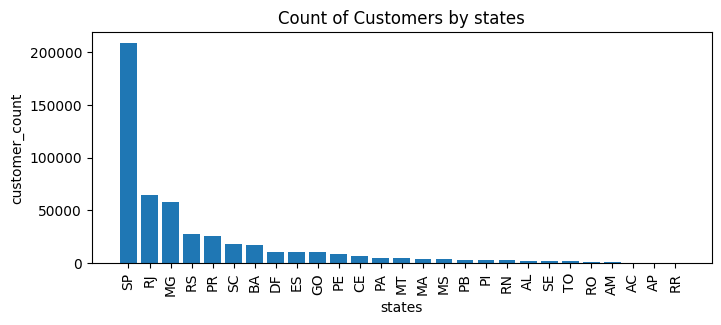

In [24]:
query = """ select customer_state, count(customer_id)
from customers  group by customer_state   """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by states")
plt.show()


##Intermediate Queries
1. Calculate the number of orders per month in 2018

<function matplotlib.pyplot.show(close=None, block=None)>

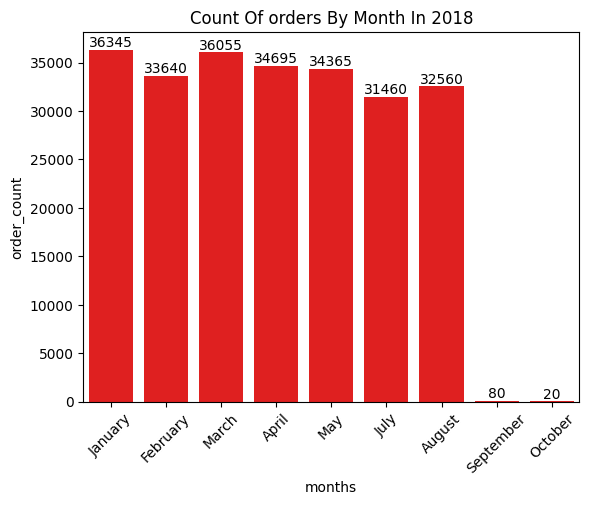

In [28]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February",'March',"April","May","July","August","September","October"]

ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,
               color="red")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count Of orders By Month In 2018")

plt.show




##2. Find the average number of products per order, grouped by customer city.

In [32]:
query = """with count_per_order as
(Select o.order_id,o.customer_id,count(oi.order_id) as oc
from orders as o join order_items as oi
on o.order_id = oi.order_id
group by o.order_id,o.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) as avgerage_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["cusotmer_city","average products per orders"])
df.head()

,cusotmer_city,average products per orders
0,treze tilias,6.36
1,indaial,5.58
2,sao jose dos campos,5.69
3,sao paulo,5.78
4,porto alegre,5.87


##3. Calculate the percentage of total revenue contributed by each product category.

In [38]:
query = """ SELECT 
p.product_category AS category, 
        (SUM(pay.payment_value)/(select sum(payment_value) from payments)*100) AS sales_percentage
    FROM 
        products AS p
    JOIN 
        order_items AS oi 
    ON 
        p.product_id = oi.product_id
    JOIN 
        payments AS pay 
    ON 
        pay.order_id = oi.order_id
    GROUP BY 
        p.product_category
        order by sales_percentage desc;   """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["category","Percentage Distribution"])
df.head()

,category,Percentage Distribution
0,bed table bath,21.395057
1,HEALTH BEAUTY,20.705683
2,computer accessories,19.805648
3,Furniture Decoration,17.867297
4,Watches present,17.855308


 4. Identify the correlation between product price and the number of times a product has been purchased.

In [47]:
import numpy as np;
query = """   select products.product_category,
        count(order_items.product_id),
        round(avg(order_items.price),2)
        from products join order_items
        on products.product_id= order_items.product_id
        group by products.product_category """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Order_count","price"])

arr1=df["Order_count"]
arr2= df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is",a[0][-1])

the correlation between product price and the number of times a product has been purchased is -0.10631514167157562


5. Calculate the total revenue generated by each seller, and rank them by revenue.


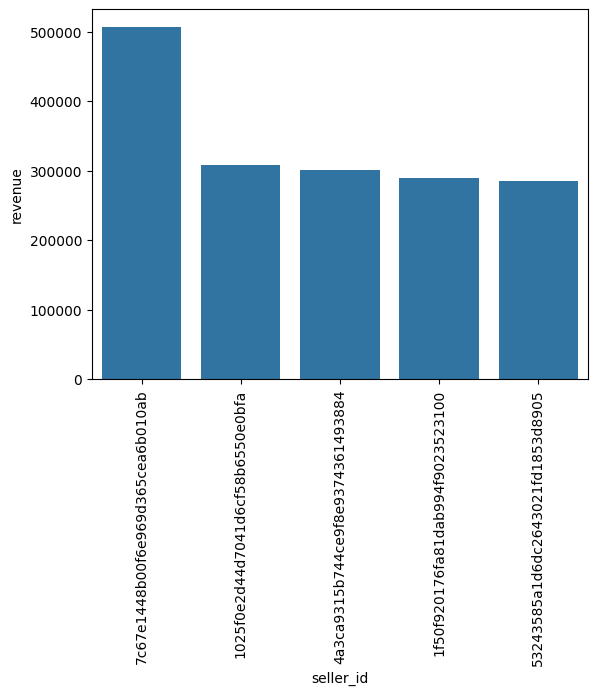

In [56]:
query = """  select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value)
as Revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head(5)
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()


Advanced Queries
1. Calculate the moving average of order values for each customer over their order history.

In [4]:


query = """ select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id  order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
519425,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519426,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519427,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519428,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


2. Calculate the cumulative sales per month for each year.

In [ ]:
query = """ select years,months,payment,sum(payment)
over (order by years,months) as cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id 
group by years,months order by years,months)as a;
 """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df

3. Calculate the year-over-year growth rate of total sales.

In [14]:
query = """ with a as
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id 
group by years order by years)

select years,((payment-lag(payment,1) over(order by years))/
lag(payment,1) over (order by years)) * 100 
from a
 """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [15]:
query=""" 
with a as( select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id= orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

5. Identify the top 3 customers who spent the most money in each year.

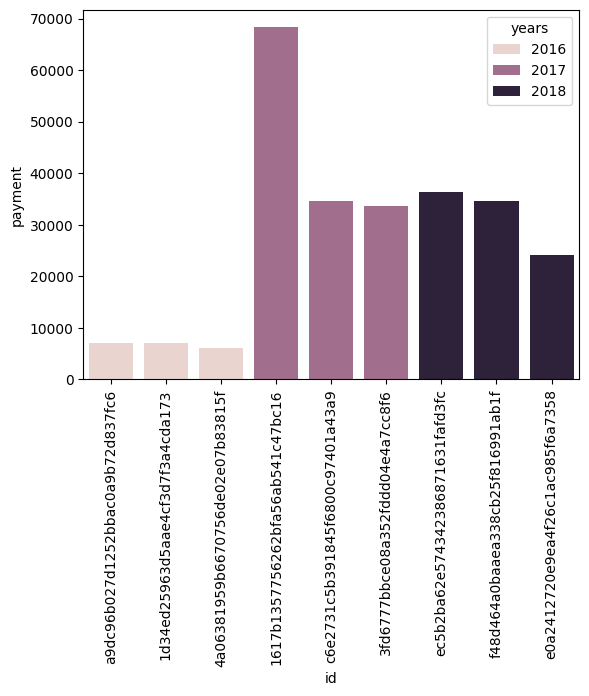

In [18]:
query="""select years,customer_id,payment,d_rank
from

(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()